Implementing Convolutional Neural Network (CNN) with Word2Vec embeddings as input to detect bugs in gaming Reviews in PyTorch

In [1]:
import pandas as pd
from collections.abc import Mapping

Exploring data

In [2]:
top_data_df = pd.read_csv("Dataset/cleanedReviewsDateset100.csv")
print("Columns in the original dataset:\n")
print(top_data_df.columns)

Columns in the original dataset:

Index(['product_id', 'page', 'page_order', 'recommended', 'date', 'bugType',
       'haveBugs', 'text', 'hours', 'username', 'products', 'early_access',
       'products_ismissing'],
      dtype='object')


In [3]:
# Function to retrieve top few number of each category
def get_top_data(top_n = 5000):
    top_data_df_positive = top_data_df[top_data_df['haveBugs'] == 1].head(top_n)
    top_data_df_negative = top_data_df[top_data_df['haveBugs'] == 0].head(top_n)
    top_data_df_small = pd.concat([top_data_df_positive, top_data_df_negative])
    return top_data_df_small

# Function call to get the top 10000 from each review
top_data_df_small = get_top_data(top_n=10000)

# After selecting top few samples of each review
print("After segregating and taking equal number of rows for each review:")
print(top_data_df_small['haveBugs'].value_counts())
top_data_df_small.head(10)

After segregating and taking equal number of rows for each review:
0    60
1    39
Name: haveBugs, dtype: int64


,product_id,page,page_order,recommended,date,bugType,haveBugs,text,hours,username,products,early_access,products_ismissing
2,108600,1,7,False,01-01-22,invalid event occurance over time,1,fun game ruined by overly punishing update mor...,180.9,kobogen,157,True,False
5,1086940,1,1,False,01-01-22,implementation response issue,1,like its definitely fun but the stability is a...,81.4,wickedmystic,142,True,False
6,1086940,1,2,True,01-01-22,information out of order,1,so many systems to learn its a bit overwhelmin...,39.2,voxix,120,True,False
8,1086940,1,6,False,01-01-22,invalid value change,1,this game needs a higher level cap not worth p...,138.3,zardu hasselfrau,37,True,False
10,1086940,1,8,True,01-01-22,"invalid graphical representation, artificial s...",1,the game has film grain that takes away the sp...,33.2,tatical,47,True,False
17,1826960,1,2,True,01-01-22,invalid event occurance over time,1,the game itself isnt bad its unique in the way...,0.9,elisabeth,12,True,False
18,1826960,1,3,False,01-01-22,invalid context state over time,1,i have to put this game down because all the h...,0.8,urimiya,114,True,False
20,1826960,1,7,True,01-01-22,artificial stupidity,1,so before us is the classic browser strategy o...,0.8,n1k0msl,26,True,False
27,887570,1,7,True,01-01-22,"lack of required information, information our ...",1,this game is cool but it is waaaaaay too niche...,4.0,918informant,187,True,False
28,887570,1,8,False,01-01-22,implementation response issue,1,it doesnt make sense that this game has overwh...,5.0,sentrysteve,188,True,False


preprocess text data:
1. Removal of Stop Words

In [4]:
# Removing the stop words
from gensim.parsing.preprocessing import remove_stopwords
print(remove_stopwords("Restaurant had a really good service!!"))
print(remove_stopwords("I did not like the food!!"))
print(remove_stopwords("This product is not good!!"))

Restaurant good service!!
I like food!!
This product good!!


Tokenization

In [5]:
from gensim.utils import simple_preprocess
# Tokenize the text column to get the new column 'tokenized_text'
top_data_df_small['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in top_data_df_small['text']] 
print(top_data_df_small['tokenized_text'].head(10))

2     [fun, game, ruined, by, overly, punishing, upd...
5     [like, its, definitely, fun, but, the, stabili...
6     [so, many, systems, to, learn, its, bit, overw...
8     [this, game, needs, higher, level, cap, not, w...
10    [the, game, has, film, grain, that, takes, awa...
17    [the, game, itself, isnt, bad, its, unique, in...
18    [have, to, put, this, game, down, because, all...
20    [so, before, us, is, the, classic, browser, st...
27    [this, game, is, cool, but, it, is, waaaaaay, ...
28    [it, doesnt, make, sense, that, this, game, ha...
Name: tokenized_text, dtype: object


Stemming

In [6]:
from gensim.parsing.porter import PorterStemmer
porter_stemmer = PorterStemmer()
# Get the stemmed_tokens
top_data_df_small['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in top_data_df_small['tokenized_text'] ]
top_data_df_small['stemmed_tokens'].head(10)

2     [fun, game, ruin, by, overli, punish, updat, m...
5     [like, it, definit, fun, but, the, stabil, is,...
6     [so, mani, system, to, learn, it, bit, overwhe...
8     [thi, game, need, higher, level, cap, not, wor...
10    [the, game, ha, film, grain, that, take, awai,...
17    [the, game, itself, isnt, bad, it, uniqu, in, ...
18    [have, to, put, thi, game, down, becaus, all, ...
20    [so, befor, us, is, the, classic, browser, str...
27    [thi, game, is, cool, but, it, is, waaaaaai, t...
28    [it, doesnt, make, sens, that, thi, game, ha, ...
Name: stemmed_tokens, dtype: object

Splitting into Train and Test Sets:
Train data would be used to train the model and test data is the data on which the model would predict the classes and it will be compared with original labels to check the accuracy or other model test metrics.
Train data ( Subset of data for training ML Model) ~70%
Test data (Subset of data for testing ML Model trained from the train data) ~30%

In [7]:
from sklearn.model_selection import train_test_split
# Train Test Split Function
def split_train_test(top_data_df_small, test_size=0.25, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(top_data_df_small[['stemmed_tokens']], 
                                                        top_data_df_small['haveBugs'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)

    print("Value counts for Train reviews")
    print(Y_train.value_counts())
    print("Value counts for Test reviews")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(top_data_df_small)

Value counts for Train reviews
0    46
1    28
Name: haveBugs, dtype: int64
Value counts for Test reviews
0    14
1    11
Name: haveBugs, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
   index                                     stemmed_tokens
0     65  [it, great, wai, to, portrai, semi, realist, p...
1     92  [thi, is, realli, fun, game, with, plenti, to,...
2     84  [return, it, interfac, imposs, to, negoti, eve...
3     37  [if, you, ar, think, of, plai, thi, in, vr, yo...
4     41  [rate, thi, posit, review, becaus, absolut, lo...


Convolutional Neural Network for Text Classification:
we are ready to dive into how will we use CNN for text classification and how the input will be constructed. CNN involves two operations, which can be thought of as feature extractors: convolution and pooling. Output of these operations is finally connected to the multi-layer perceptron to get the final output.
Generating input and output tensor:

In [8]:
from gensim.models import Word2Vec
size = 500
window = 3
min_count = 1
workers = 3
sg = 1

# Function to train word2vec model
def make_word2vec_model(top_data_df_small, padding=True, sg=1, min_count=1, size=500, workers=3, window=3):
    if  padding:
        print(len(top_data_df_small))
        temp_df = pd.Series(top_data_df_small['stemmed_tokens']).values
        temp_df = list(temp_df)
        temp_df.append(['pad'])
        word2vec_file = 'CNN/' + 'models/' + 'word2vec_' + str(size) + '_PAD.model'
    else:
        temp_df = top_data_df_small['stemmed_tokens']
        word2vec_file = 'CNN/' + 'models/' + 'word2vec_' + str(size) + '.model'
    w2v_model = Word2Vec(temp_df, min_count = min_count, vector_size = size, workers = workers, window = window, sg = sg)

    w2v_model.save(word2vec_file)
    return w2v_model, word2vec_file

# Train Word2vec model
w2vmodel, word2vec_file = make_word2vec_model(top_data_df_small, padding=True, sg=sg, min_count=min_count, size=size, workers=workers, window=window)


99


Once the model is ready, we can create a function to generate input tensor.

In [9]:
max_sen_len = top_data_df_small.stemmed_tokens.map(len).max()
padding_idx = w2vmodel.wv.key_to_index["pad"]

def make_word2vec_vector_cnn(sentence):
    padded_X = [padding_idx for i in range(max_sen_len)]
    i = 0
    for word in sentence:
        if word not in w2vmodel.wv:
            padded_X[i] = 0
            print(word)
        else:
            padded_X[i] = w2vmodel.wv.key_to_index[word]
        i += 1
    return torch.tensor(padded_X, dtype=torch.long, device=device).view(1, -1)

In [10]:
# Function to get the output tensor
def make_target(label):
    if label == -1:
        return torch.tensor([0], dtype=torch.long, device=device)
    elif label == 0:
        return torch.tensor([1], dtype=torch.long, device=device)
    else:
        return torch.tensor([2], dtype=torch.long, device=device)

Defining CNN

In [11]:
EMBEDDING_SIZE = 500
NUM_FILTERS = 10
import gensim
import torch.nn as nn
import torch

class CnnTextClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes, window_sizes=(1,2,3,5)):
        super(CnnTextClassifier, self).__init__()
        w2vmodel = gensim.models.KeyedVectors.load('CNN/' + 'models/' + 'word2vec_500_PAD.model')
        weights = w2vmodel.wv
        # With pretrained embeddings
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights.vectors), padding_idx=w2vmodel.wv.key_to_index['pad'])
        # Without pretrained embeddings
        # self.embedding = nn.Embedding(vocab_size, EMBEDDING_SIZE)

        self.convs = nn.ModuleList([
                                   nn.Conv2d(1, NUM_FILTERS, [window_size, EMBEDDING_SIZE], padding=(window_size - 1, 0))
                                   for window_size in window_sizes
        ])

        self.fc = nn.Linear(NUM_FILTERS * len(window_sizes), num_classes)

    def forward(self, x):
        x = self.embedding(x) # [B, T, E]

        # Apply a convolution + max_pool layer for each window size
        x = torch.unsqueeze(x, 1)
        xs = []
        for conv in self.convs:
            x2 = torch.tanh(conv(x))
            x2 = torch.squeeze(x2, -1)
            x2 = F.max_pool1d(x2, x2.size(2))
            xs.append(x2)
        x = torch.cat(xs, 2)

        # FC
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        probs = F.softmax(logits, dim = 1)

        return probs

In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cpu


Train CNN Model

In [13]:
NUM_CLASSES = 3
VOCAB_SIZE = len(w2vmodel.wv)

cnn_model = CnnTextClassifier(vocab_size=VOCAB_SIZE, num_classes=NUM_CLASSES)
cnn_model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
num_epochs = 30

# Open the file for writing loss
loss_file_name = 'CNN/' +  'plots/' + 'cnn_class_big_loss_with_padding.csv'
f = open(loss_file_name,'w')
f.write('iter, loss')
f.write('\n')
losses = []
cnn_model.train()
for epoch in range(num_epochs):
    print("Epoch" + str(epoch + 1))
    train_loss = 0
    for index, row in X_train.iterrows():
        # Clearing the accumulated gradients
        cnn_model.zero_grad()

        # Make the bag of words vector for stemmed tokens 
        bow_vec = make_word2vec_vector_cnn(row['stemmed_tokens'])
       
        # Forward pass to get output
        probs = cnn_model(bow_vec)

        # Get the target label
        target = make_target(Y_train['haveBugs'][index])

        # Calculate Loss: softmax --> cross entropy loss
        loss = loss_function(probs, target)
        train_loss += loss.item()

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()


    # if index == 0:
    #     continue
    print("Epoch ran :"+ str(epoch+1))
    f.write(str((epoch+1)) + "," + str(train_loss / len(X_train)))
    f.write('\n')
    train_loss = 0

torch.save(cnn_model, 'CNN/' + 'cnn_big_model_500_with_padding.pth')

f.close()
print("Input vector")
print(bow_vec.cpu().numpy())
print("Probs")
print(probs)
print(torch.argmax(probs, dim=1).cpu().numpy()[0])

Epoch1


KeyboardInterrupt: 

Testing the model

Index(['iter', ' loss'], dtype='object')
              precision    recall  f1-score   support

           1       0.67      1.00      0.80        14
           2       1.00      0.36      0.53        11

    accuracy                           0.72        25
   macro avg       0.83      0.68      0.67        25
weighted avg       0.81      0.72      0.68        25

Index(['iter', ' loss'], dtype='object')


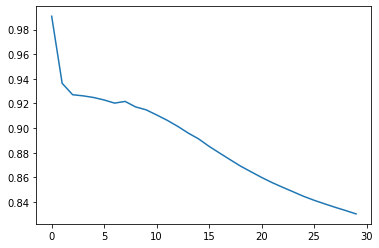

In [ ]:
from sklearn.metrics import classification_report
bow_cnn_predictions = []
original_lables_cnn_bow = []
cnn_model.eval()
loss_df = pd.read_csv('CNN/' +  'plots/' +'cnn_class_big_loss_with_padding.csv')
print(loss_df.columns)
# loss_df.plot('loss')
with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_word2vec_vector_cnn(row['stemmed_tokens'])
        probs = cnn_model(bow_vec)
        _, predicted = torch.max(probs.data, 1)
        bow_cnn_predictions.append(predicted.cpu().numpy()[0])
        original_lables_cnn_bow.append(make_target(Y_test['haveBugs'][index]).cpu().numpy()[0])
print(classification_report(original_lables_cnn_bow,bow_cnn_predictions))
loss_file_name = 'CNN/' +  'plots/' + 'cnn_class_big_loss_with_padding.csv'
loss_df = pd.read_csv(loss_file_name)
print(loss_df.columns)
plt_500_padding_30_epochs = loss_df[' loss'].plot()
fig = plt_500_padding_30_epochs.get_figure()
fig.savefig('CNN/' +'plots/' + 'loss_plt_500_padding_30_epochs.pdf')